# tutorial3.ipynb

A network of excitatory and inhibitory units with plastic synapses.

The previous tutorials have already provided all the tools required to create more complex simulations. In this tutorial a network with the following properties will be created:
* It will have 3 populations of units, called `exc`, `inh`, and `inp`. Those populations will have excitatory, inhibitory, and source units respectively.
* Each population will be arranged in a NxN grid where each unit is 1 length unit away from its neighbours. The grids have periodic boundaries, so units at the very top of the grid are nearby units at the bottom, and units at the far left are close to units on the right.
 * Excitatory units send projections to nearby excitatory units (using a 'disk' mask), and to inhibitory units at intermediate distances (using an 'annular' mask). E-E projections use Hebbian learning with substractive normalization, whereas E-I connections are static. 
 * Inhibitory units send projections to nearby excitatory units. These connections use a "homeostatic" learning rule that maintains a desired level of activity in excitatory units, as described [here](http://www.pnas.org/content/103/44/16526.short?related-urls=yes&legid=pnas;103/44/16526).
 * Input units send projections to nearby units.

What is expected is that the units in the network will self-organize into groups that respond to particular inputs.

It will become obvious that writing this simulation involves typing a lot of parameters, and writing code to visualize things. For these reason we create classes that help with these tasks. The main aim of the tutorial is to show users one particular approach to write a more complex simulation. It is thus not necessary to follow every line of code; getting the general idea of the approach is enough. A different approach will be shown with the ei_net module.

Although the properties of the network may be interesting, numerical analysis of simulation results is beyond the scope of this tutorial. On the other hand, many visualization procedures are presented.

## Part 1
A network where units respond selectively to inputs.

Cortical neurons in primary sensory regions tend to respond to particular stimuli. A prominent example is macaque primary visual cortex, where neurons respond to particular colors, orientations, and directions of movement (see the introduction [here](https://www.sciencedirect.com/science/article/pii/S096098221731521X)).

A large number of models exist to explain how neurons develop this *selectivity*. In here we take some basic features of those models to create a layer with plastic connections, and provide a variety of inputs. We can then ask whether the units in our layer resemble real neurons.

In [1]:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

/home/z/projects/draculab


The model has a lot of parameters. It is convenient to keep them all in one place. In this case a class is created for this puprpose.

In [2]:
class parameters():
    """
        Instances of this class contain all the parameters used by the 'selection' class.
        
        All parameters derived from other parameters will be recalculated in 
        selection.__init__ . They're here too for readability.
    """
    def __init__(self):
        ########################## Here be all parameters
        # NETWORK PARAMETERS 
        self.md = 0.1 # minimum delay in the network
        self.min_buff_size = 5 # minimum buffer size
        self.rtol = 1e-4 # relative tolerance of the ODE solver
        self.atol = 1e-4 # absolute tolerance of the ODE solver
        self.N = 5 # The network's layers will have size NxN
        N = self.N # for brevity
        self.L = N/2. + 2./N # side length of rectangle with the square grids.
        L = self.L
        
        # EXCITATORY UNIT PARAMETERS
        self.exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        self.exc_init_val = np.random.uniform(0.1, 0.6, N*N)  # initial activations (around IE_des_act)
        self.exc_tau_fast = 0.2  # time constant of the fast low-pass filter
        self.exc_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        self.fe_thr = 0.3 # threshold of the f-I curve
        self.fe_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the excitatory units
        self.exc_shape = 'sheet'
        self.exc_extent = [L, L]
        self.exc_arrangement = 'grid'
        self.exc_rows = N
        self.exc_columns = N
        self.exc_center = [0., 0.]
        
        # INHIBITORY UNIT PARAMETERS
        self.inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        self.inh_init_val = np.random.uniform(0.1, 0.6, N*N)  # initial activations
        self.inh_tau_fast = 0.2  # time constant of the fast low-pass filter
        self.inh_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        self.fi_thr = 0.4 # threshold of the f-I curve
        self.fi_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the inhibitory units
        self.inh_shape = 'sheet'
        self.inh_extent = [L, L]
        self.inh_arrangement = 'grid'
        self.inh_rows = N
        self.inh_columns = N
        self.inh_center = [0., 0.]
        
        # INPUT UNIT PARAMETERS
        self.inp_init_val = 0.2 # initial activation
        self.inp_tau_fast = 0.2 # time constant of the fast low-pass filter
        # geometrical arrangement of the input units
        self.inp_shape = 'sheet'
        self.inp_extent = [L, L]
        self.inp_arrangement = 'grid'
        self.inp_rows = N
        self.inp_columns = N
        self.inp_center = [0., 0.]
        
        # E-I CONNECTIONS
        self.EI_connection_type = 'convergent'
        self.EI_mask = {'annular':{'inner_radius' : 1.1, 'outer_radius':4.1}}
        self.EI_kernel = {'linear' : {'c' : 1., 'a' : 0.2}}
        self.EI_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.EI_weights = {'uniform' : {'low' : 0.5, 'high' : 0.8}}
        self.EI_edge_wrap = True
        self.EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.EI_type = synapse_types.static
        
        # E-E CONNECTIONS
        self.EE_connection_type = 'divergent'
        self.EE_mask = {'circular':{'radius':2.}}
        self.EE_kernel = {'gaussian' : {'p_center' : 1., 'sigma' : 1.}}
        self.EE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.EE_weights =  {'uniform' : {'low' : 0.1, 'high' : 0.6}}
        self.EE_edge_wrap = True
        self.EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.EE_type = synapse_types.sq_hebbsnorm 
        self.EE_lrate = 1./200. # learning rate
        self.EE_omega = 2.5  # sum of squared EE weights 
        
        # I-E CONNECTIONS
        self.IE_connection_type = 'divergent'
        self.IE_mask = {'circular':{'radius':2.}}
        self.IE_kernel = {'gaussian' : {'p_center' : 1.4, 'sigma' : 1.}}
        self.IE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.IE_weights =  {'uniform' : {'low' : -0.6, 'high' : -0.1}}
        self.IE_edge_wrap = True
        self.IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.IE_type = synapse_types.homeo_inh
        self.IE_lrate = 1./100. 
        self.IE_des_act = 0.3
        
        # INP_EXC CONNECTIONS
        self.PE_connection_type = 'divergent'
        self.PE_mask = {'circular':{'radius':3.5}}
        self.PE_kernel = 0.6
        self.PE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.PE_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        self.PE_edge_wrap = True
        self.PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.PE_type = synapse_types.bcm
        self.PE_lrate = 1./200.
        
        # INP_INH CONNECTIONS
        self.PI_connection_type = 'divergent'
        self.PI_mask = {'circular':{'radius':3.5}}
        self.PI_kernel = 0.6
        self.PI_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.PI_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        self.PI_edge_wrap = True
        self.PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.PI_type = synapse_types.bcm
        self.PI_lrate = 1./200.
        
        # PATTERN PRESENTATION
        self.t_pat = 20. # time each pattern will be presented
        self.t_trans = 5. # length of transition period between patterns
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
        self.pat_type = 'lines' # see selection.build()

It is also useful to create a class that contains all the procedures that will be repeatedly used during simulations. That is the role of the `selection` class.

The `selection` class is initialized with a parameter object, and then its `build` procedure is invoked to create a draculab network as specified in the parameter object. Additionaly, `build` also creates input patterns, which can be one of three types: "random", "snake", or "lines". The type of input is specified in the `pat_type` attribute of the parameters object.

Once the network has been built, simualations can be run with the `run` procedure.

Other methods in the `selection` class will be shown later. These include:
* `animate_responses` -- creates an animation of how much each unit activated in response to each input pattern.
* `display_inputs` -- creates a grid image with all the input patterns.
* `view_weight_grid` -- visualize the synaptic weigths in a grid of images. 

In [3]:
class selection():
    def __init__(self, p):
        """ Initialize parameter dictionaries using the parameter object p. """
        # optionally, seed the random number generator
        #np.random.seed(54321)
        
        ########################## Initialize derived parameters
        N = p.N; # N is used often. Might as well make a local copy.
        p.L = N/2. + 2./N # side length of the square unit grids   
        L = p.L
        p.exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        p.exc_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        p.exc_extent = [L, L]
        p.exc_rows = N
        p.exc_columns = N
        p.inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        p.inh_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        p.inh_extent = [L, L]
        p.inh_rows = N
        p.inh_columns = N
        p.inp_extent = [L, L]
        p.inp_rows = N
        p.inp_columns = N
        p.EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.EI_delays['linear']['c'] = p.md
        p.EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.EE_delays['linear']['c'] = p.md
        p.IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.IE_delays['linear']['c'] = p.md
        p.PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.PE_delays['linear']['c'] = p.md
        p.PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.PI_delays['linear']['c'] = p.md
        # stuff used to create input functions
        self.t_trans = p.t_trans
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
        self.t_pat = p.t_pat
        self.params = p
        
        ########################## Initialize all the parameter dictionaries 
        self.net_params = {'min_delay' : p.md, 
                           'min_buff_size' : p.min_buff_size, 
                           'rtol':p.rtol, 
                           'atol':p.atol } 
        self.exc_params = {'tau' : p.exc_tau,
                           'function' : self.make_fe(p.fe_thr, p.fe_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : p.exc_init_val, 
                           'tau_fast' : p.exc_tau_fast, 
                           'tau_slow' : p.exc_tau_slow } # tau_slow vs lrate controls stability of BCM
        self.exc_geom = {'shape' : p.exc_shape, 
                         'extent' : p.exc_extent, 
                         'arrangement' : p.exc_arrangement, 
                         'rows' : p.exc_rows, 
                         'columns' : p.exc_columns, 
                         'center' : p.exc_center }
        self.inh_params = {'tau' :p.inh_tau, 
                           'function' : self.make_fi(p.fi_thr, p.fi_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : p.inh_init_val, 
                           'tau_fast' : p.inh_tau_fast, 
                           'tau_slow' : p.inh_tau_slow }
        self.inh_geom = {'shape' : p.inh_shape, 
                         'extent' : p.inh_extent, 
                         'arrangement' : p.inh_arrangement, 
                         'rows' : p.inh_rows, 
                         'columns' : p.inh_columns, 
                         'center' : p.inh_center }
        self.inp_params = {'type' : unit_types.source, 
                           'init_val' : p.inp_init_val, 
                           'tau_fast' : p.inp_tau_fast, 
                           'function' : lambda x: None }
        self.inp_geom = {'shape' : p.inp_shape, 
                         'extent' : p.inp_extent, 
                         'arrangement' : p.inp_arrangement, 
                         'rows' : p.inp_rows, 
                         'columns' : p.inp_columns, 
                         'center' : p.inp_center }
        self.EI_conn = {'connection_type' : p.EI_connection_type,
                        'mask' : p.EI_mask,
                        'kernel' : p.EI_kernel,
                        'delays' : p.EI_delays,
                        'weights' : p.EI_weights,
                        'edge_wrap' : p.EI_edge_wrap,
                        'boundary' : p.EI_boundary }
        self.EI_syn = {'type' : p.EI_type }
        self.EE_conn = {'connection_type' : p.EE_connection_type,
                        'mask' : p.EE_mask,
                        'kernel' : p.EE_kernel,
                        'delays' : p.EE_delays,
                        'weights' : p.EE_weights,
                        'edge_wrap' : p.EE_edge_wrap,
                        'boundary' : p.EE_boundary }
        self.EE_syn = {'type' : p.EE_type, 
                       'lrate' : p.EE_lrate, 
                       'omega' : p.EE_omega } 
        self.IE_conn = {'connection_type' : p.IE_connection_type,
                        'mask' : p.IE_mask,
                        'kernel' : p.IE_kernel,
                        'delays' : p.IE_delays,
                        'weights' : p.IE_weights,
                        'edge_wrap' : p.IE_edge_wrap,
                        'boundary' : p.IE_boundary }
        self.IE_syn = {'type' : p.IE_type, 
                       'lrate' : p.IE_lrate, 
                       'des_act' : p.IE_des_act }
        self.PE_conn = {'connection_type' : p.PE_connection_type,
                        'mask' : p.PE_mask,
                        'kernel' : p.PE_kernel,
                        'delays' : p.PE_delays,
                        'weights' : p.PE_weights,
                        'edge_wrap' : p.PE_edge_wrap,
                        'boundary' : p.PE_boundary }
        self.PE_syn = {'lrate' : p.PE_lrate, 
                       'type' : p.PE_type }
        self.PI_conn = {'connection_type' : p.PI_connection_type,
                        'mask' : p.PI_mask,
                        'kernel' : p.PI_kernel,
                        'delays' : p.PI_delays,
                        'weights' : p.PI_weights,
                        'edge_wrap' : p.PI_edge_wrap,
                        'boundary' : p.PI_boundary }
        self.PI_syn = {'lrate' : p.PI_lrate, 
                       'type' : p.PI_type }
        
    def build(self):            
        topo = topology() # the topology class. Used to create spatially patterned connections
        #build network
        self.net = network(self.net_params)
        # build units
        self.exc = topo.create_group(self.net, self.exc_geom, self.exc_params)
        self.inh = topo.create_group(self.net, self.inh_geom, self.inh_params)
        self.inp = topo.create_group(self.net, self.inp_geom, self.inp_params)
        # build connections
        topo.topo_connect(self.net, self.exc, self.inh, self.EI_conn, self.EI_syn)
        topo.topo_connect(self.net, self.exc, self.exc, self.EE_conn, self.EE_syn)
        topo.topo_connect(self.net, self.inh, self.exc, self.IE_conn, self.IE_syn)
        topo.topo_connect(self.net, self.inp, self.exc, self.PE_conn, self.PE_syn)
        topo.topo_connect(self.net, self.inp, self.inh, self.PI_conn, self.PI_syn)
        
        # create the input patterns
        N = self.inp_geom['rows'] # number of patterns based on input layer size
        if self.params.pat_type == 'random':
            n_pat = int(round(1.5*N))  # number of different patterns
            n_ones = int(round(N*N)/3) # number of ones in the input patterns
            basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
            basic_pat = basic_pat/np.sqrt(sum(basic_pat)) # normalizing
            self.patterns = [basic_pat.copy() for i in range(n_pat)]
            for pat in self.patterns:
                np.random.shuffle(pat)
        elif self.params.pat_type == 'snake': # intersecting lines
            n_pat = int(round(1.5*N))  # number of different patterns
            length = int(round(N*N/3.))
            advance = int(round(N*N/n_pat))
            base = np.zeros(N*N)
            base[0:length] = np.ones(length)/np.sqrt(length)
            self.patterns = [np.zeros(N*N) for _ in range(n_pat)]
            for pat in range(n_pat):
                self.patterns[pat] = np.roll(base, pat*advance)
        elif self.params.pat_type == 'lines': # separate lines
            n_pat = N  # number of different patterns
            self.patterns = [np.zeros((N,N)) for _ in range(n_pat)]
            for num,pat in enumerate(self.patterns):
                if num < N:
                    pat[:,num] = np.ones(N)
                    self.patterns[num] = pat.reshape(N*N, order='F') 
                    # the conversion from shape N*N to shape (N,N) must follow the index-location
                    # relation created by create_group using grid arrangement
        
        # print average number of connections of each type
        sum_ee = 0 # number of e-e connections
        sum_ei = 0
        sum_ie = 0
        sum_pe = 0 # number of input to exc connections
        sum_pi = 0
        for syn_list in self.net.syns:
            for syn in syn_list:
                if syn.postID in self.exc:
                    if syn.preID in self.exc:
                        sum_ee += 1
                    elif syn.preID in self.inh:
                        sum_ie += 1
                    else:
                        sum_pe += 1
                elif syn.postID in self.inh:
                    if syn.preID in self.exc:
                        sum_ei += 1
                    else:
                        sum_pi += 1
        Nsq = self.params.N * self.params.N
        print("Average number of incoming EE connections: %f" % (sum_ee/Nsq))
        print("Average number of incoming EI connections: %f" % (sum_ei/Nsq))
        print("Average number of incoming IE connections: %f" % (sum_ie/Nsq))
        print("Average number of incoming PE connections: %f" % (sum_pe/Nsq))
        print("Average number of incoming PI connections: %f" % (sum_pi/Nsq))
        
    def make_fe(self, th, eps): # returns a function as in Eq. 1 of the paper
        return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
    
    def make_fi(self, th, eps): # returns a function as in Eq. 2 of the paper
        return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
    
    def make_pulse(self, t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
        return lambda t : 1. if (t_init < t and t < t_end) else 0.
    
    def make_sin_pulse(self, t_init, t_end, per): # the stimulus used in Moldakarimov et al.
        return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
    
    def plot_stuff(self, data): 
        N = self.params.N
        fig = plt.figure(figsize=(8,8))
        upper = 1.1*max([max(data[1][u]) for u in self.exc+self.inp+self.inh])
        for i in range(N*N):
            ax = fig.add_subplot(N,N,i+1)
            ax.clear()
            plt.ylim(-0.02, upper)
            ax.plot(data[0], data[1][self.exc[i]], 'b', data[0], data[1][self.inh[i]], 'r',
                    data[0], data[1][self.inp[i]], 'k', figure=fig)
        plt.show()
        
    def make_fun1(self, cur_pat, idx):  
        # This creates a constant function with value: patterns[cur_pat][idx]
        # thus avoiding a scoping problem that is sometimes hard to see:
        # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
        fun = lambda t : self.patterns[cur_pat][idx]
        return fun

    def make_fun2(self, cur_pat, next_pat, idx, last_t):
        # Creates a function for the pattern transition
        fun = lambda t : self.c * ( (self.t_trans - (t-last_t))*self.patterns[cur_pat][idx] +
                                    (t-last_t)*self.patterns[next_pat][idx] )
        return fun

    def run(self, n_pres, n_disp):
        """ Run a simulation.
            
            Args:
                n_pres: (int) number of times an input pattern will be presented. 
                n_disp: (int) number of times outputs will be displayed during the simulation.
        """
        %matplotlib inline
        N = self.params.N
        n_pat = len(self.patterns) # variable for number of distinct patterns
        display = [int(round(n)) for n in (n_pres/n_disp)*np.array(range(n_disp+1))] # when to display info
        idx_d = 0 # index for display data
        self.exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
        self.inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
        self.inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
        
        cur_pat = np.random.randint(n_pat)  
        next_pat = np.random.randint(n_pat)
        self.all_avg_res = [[np.zeros(N*N) for _ in range(n_pat)] for _ in range(n_pres)]
        
        for pres in range(n_pres):
            # For each cycle you'll set the input functions and simulate, 
            # once with a single pattern, once with a mix of patterns
            # first, we present a single pattern
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function( self.make_fun1(cur_pat, u) )
    
            start_time = time.time()
            times, units, plants = self.net.run(self.t_pat)  # simulating
            last_t = self.net.sim_time # simulation time after last pattern presentation
    
            #self.plot_stuff((times,units))
            #print('Fixed pattern presented: ' + str(cur_pat))
            
            # store the average activation level for each excitatory unit
            # all_avg_res[pres][pat][u] = Avg.Act. for unit u whe pattern pat is presented as of pres
            if pres > 0:
                for pats in range(n_pat):
                    if pats != cur_pat:
                        self.all_avg_res[pres][pats] = self.all_avg_res[pres-1][pats].copy()
            for u in range(N*N):
                self.all_avg_res[pres][cur_pat][u] = sum(units[self.exc[u]]) / len(units[self.exc[u]])
            
            # now one pattern turns into the next
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function(self.make_fun2(cur_pat, next_pat, u, last_t))
    
            times2, units2, plants2 = self.net.run(self.t_trans) # simulating
    
            print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
            #self.plot_stuff((times2,units2))
            #print('Transitioned to pattern: ' + str(next_pat))

            # plot a grid with the average responses
            #avg_fig, avg_ax = plt.subplots()
            #self.all_avg_res[pres][cur_pat].shape = N,N 
            #avg_ax.imshow(self.all_avg_res[pres][cur_pat])
            #self.all_avg_res[pres][cur_pat].shape = N*N,1
            #plt.show()
            
            # choose the pattern you'll present next
            cur_pat = next_pat
            next_pat = np.random.randint(n_pat)
            
            if pres == 0 or (pres+1) in display:
                self.plot_stuff((times,units))
                #self.plot_stuff((times2,units2))
                avg_fig = plt.figure(figsize=(9,9))
                largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pat)]) for a in range(n_pres)])
                for res in self.all_avg_res[pres]:
                    res.shape = N*N
                for u in range(N*N):
                    ax = avg_fig.add_subplot(N,N,u+1)
                    ax.plot(range(n_pat), [self.all_avg_res[pres][i][u] for i in range(n_pat)], 'bo-')
                    plt.ylim([-0.02, largest])
                plt.show()
                # store the synaptic weights
                self.exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        
                for u in self.exc: # for each excitatory unit, record its incoming weights
                    for syn_list in [self.net.syns[u]]: # recording weights for excitatory units
                        for syn in syn_list:
                            if syn.preID in self.exc: # lateral excitatory connection
                                self.exc_w[idx_d][u][syn.preID-self.exc[0]] = syn.w
                            elif syn.preID in self.inh: # lateral inhibitory connection
                                self.inh_w[idx_d][u][syn.preID-self.inh[0]] = syn.w
                            elif syn.preID in self.inp: # descending connection
                                self.inp_w[idx_d][u][syn.preID-self.inp[0]] = syn.w
                            else:
                                print("What???")
                print('Presentation ' + str(pres+1))
                idx_d += 1
            
    def animate_responses(self, interv):
        """For each unit, plot its avg. response for each pattern and for each presentation, as a movie.
        
        To use this:
        1) Run the simulation
        2) from matplotlib.animation import FuncAnimation
        3  %matplotlib notebook
        3) animate_responses(50)
        4) plt.show()
        """
        #%matplotlib qt5
        %matplotlib notebook
        self.all_avg_fig = plt.figure(figsize=(8,8))
        N = self.params.N
        n_pats = len(self.patterns)
        n_pres = len(self.all_avg_res)
        
        for pres in self.all_avg_res:
            for res in pres:
                res.shape = N*N
        for u in range(N*N):
            ax = self.all_avg_fig.add_subplot(N,N,u+1)

        self.max_avg = max([max([max(self.all_avg_res[a][b]) for b in range(n_pats)]) for a in range(n_pres)])
        animation = FuncAnimation(self.all_avg_fig, self.update_anim, interval=interv, blit=True)
        return animation
        
    def update_anim(self, frame):
        n_pres = len(self.all_avg_res)
        n_pats = len(self.patterns)
        pres = frame%n_pres
        self.all_avg_fig.suptitle('Presentation: ' + str(pres))
        for u in range(self.params.N*self.params.N):
            ax = self.all_avg_fig.add_subplot(self.params.N,self.params.N,u+1)
            ax.clear()
            ax.plot(range(n_pats), [self.all_avg_res[pres][i][u] for i in range(n_pats)], 'bo-')
            plt.ylim([-0.02, self.max_avg])          
        return ax,
           
    def display_inputs(self):
        # visualize the input patterns in a grid
        %matplotlib inline
        n_pat = len(self.patterns)
        inp_fig = plt.figure(figsize=(6,8))
        cols = int(np.ceil(np.sqrt(n_pat)))
        rows = int(round(np.sqrt(n_pat)))
        inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')
        for idx,pat in enumerate(self.patterns):
            copy = pat.copy() # to avoid reshaping the input vectors
            copy.shape = self.params.N, self.params.N
            copy = np.transpose(copy)
            inp_grid[idx].set_xticks([])
            inp_grid[idx].set_yticks([])
            inp_grid[idx].imshow(copy)
        #inp_fig.suptitle('Input patterns')
        plt.show()
        
    def view_weight_grid(self):
        # visualize the weights in a grid after the simulation
        %matplotlib inline
        N = self.params.N
        # First, a solitary plot of the E-I weights
        ei_w = [np.zeros(N*N) for _ in range(N*N)] # each entry lists all incoming weights for a unit
        for idx, uid in enumerate(self.inh):
            for syn in self.net.syns[uid]:
                if syn.preID in self.exc:
                    ei_w[idx][syn.preID - self.exc[0]] = syn.w
        ei_fig = plt.figure(figsize=(11,7))
        ei_grid = ImageGrid(ei_fig, 111, nrows_ncols=(N,N), share_all=True, label_mode="L",
                            axes_pad=0.05, cbar_location="top", cbar_mode="single", )
        for idx, ei in enumerate(ei_w):
            ei.shape = N,N
            eiim = ei_grid[idx].imshow(ei)
        ei_grid.cbar_axes[0].colorbar(eiim)
        ei_fig.suptitle('E-I weights')
        
        # Now, plots of EE, IE, and PE weights for each stored presentation
        n_disp = len(self.exc_w)
        for vis in range(n_disp):
            w_fig = plt.figure(figsize=(30,10))
            exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                             axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column", )
            for idx,exw in enumerate(self.exc_w[vis]):
                exw.shape = N,N
                exim = exw_grid[idx].imshow(np.transpose(exw))
            exw_grid.cbar_axes[0].colorbar(exim)  
            inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column" )
            for idx,inw in enumerate(self.inh_w[vis]):
                inw.shape = N,N
                inim = inw_grid[idx].imshow(np.transpose(inw))
            inw_grid.cbar_axes[0].colorbar(inim)           
            ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                                 axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column")
            for idx,ipw in enumerate(self.inp_w[vis]):
                ipw.shape = N,N
                ipim = ipw_grid[idx].imshow(np.transpose(ipw))
            ipw_grid.cbar_axes[0].colorbar(ipim)           
            if vis == 0:
                w_fig.suptitle('E-E,  I-E,  INP-E', fontsize=30)
            plt.show()
    
        # see how the sum of each type of input weights evolves for unit 0
        exc_sums = [sum(sum(self.exc_w[ii][0]*self.exc_w[ii][0])) for ii in range(n_disp)]
        inh_sums = [sum(sum(self.inh_w[ii][0])) for ii in range(n_disp)]
        inp_sums = [sum(sum(self.inp_w[ii][0])) for ii in range(n_disp)]
        print("Excitatory squared sums:", end='\t')
        print(exc_sums)
        print("Inhibitory sums:", end='\t')
        print(inh_sums)
        print("External input sums:", end=' \t')
        print(inp_sums)

After defining the `selection` class it is time to use it.

Average number of incoming EE connections: 26.270000
Average number of incoming EI connections: 38.580000
Average number of incoming IE connections: 34.300000
Average number of incoming PE connections: 59.420000
Average number of incoming PI connections: 59.750000


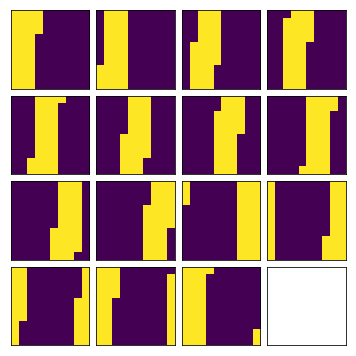

Execution time: at iteration 0 is 8.458481311798096 seconds


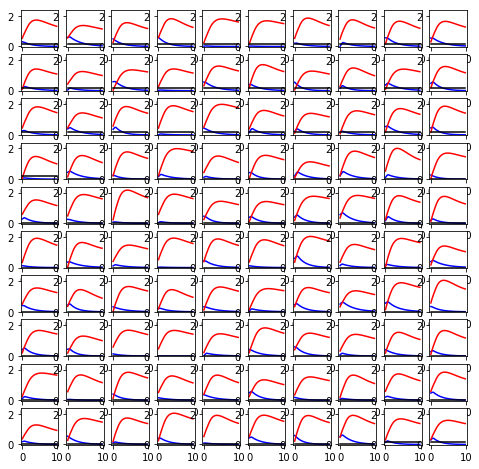

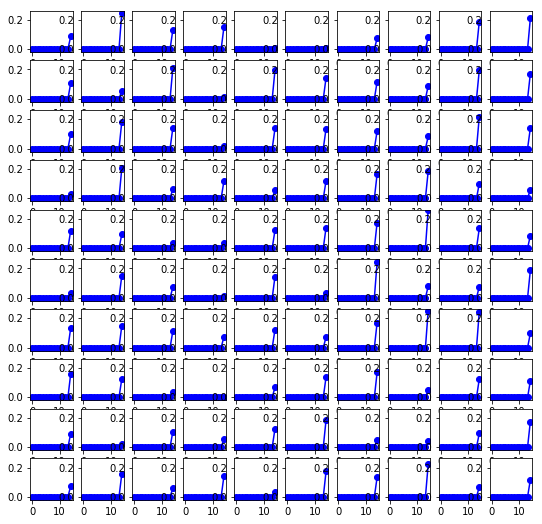

Presentation 1
Execution time: at iteration 1 is 8.473447561264038 seconds
Execution time: at iteration 2 is 8.346309423446655 seconds
Execution time: at iteration 3 is 8.272194385528564 seconds
Execution time: at iteration 4 is 8.344194650650024 seconds
Execution time: at iteration 5 is 8.310228109359741 seconds
Execution time: at iteration 6 is 8.349152565002441 seconds
Execution time: at iteration 7 is 8.375688791275024 seconds
Execution time: at iteration 8 is 8.36193585395813 seconds
Execution time: at iteration 9 is 8.36715579032898 seconds
Execution time: at iteration 10 is 8.38309907913208 seconds
Execution time: at iteration 11 is 8.511333703994751 seconds
Execution time: at iteration 12 is 8.457581281661987 seconds
Execution time: at iteration 13 is 8.426881551742554 seconds
Execution time: at iteration 14 is 8.405601501464844 seconds


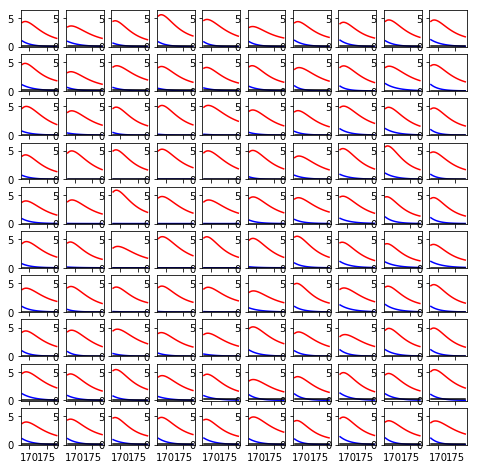

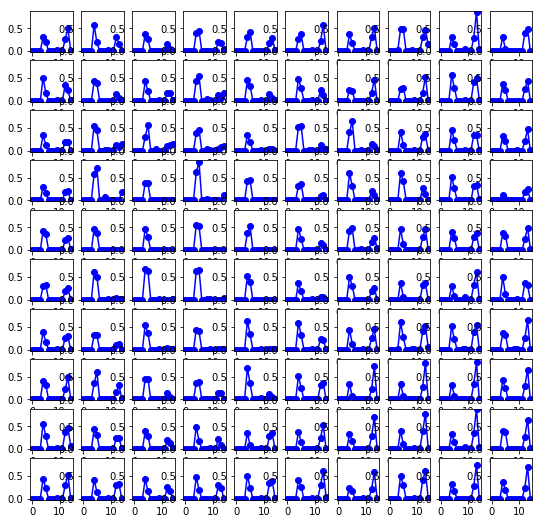

Presentation 15
Execution time: at iteration 15 is 8.373755693435669 seconds
Execution time: at iteration 16 is 8.32449460029602 seconds
Execution time: at iteration 17 is 8.309858560562134 seconds
Execution time: at iteration 18 is 8.290425539016724 seconds
Execution time: at iteration 19 is 8.324068546295166 seconds
Execution time: at iteration 20 is 8.340697765350342 seconds
Execution time: at iteration 21 is 8.33886170387268 seconds
Execution time: at iteration 22 is 8.291365623474121 seconds
Execution time: at iteration 23 is 8.253466844558716 seconds
Execution time: at iteration 24 is 8.326134443283081 seconds
Execution time: at iteration 25 is 8.43597960472107 seconds
Execution time: at iteration 26 is 8.390550136566162 seconds
Execution time: at iteration 27 is 8.305481195449829 seconds
Execution time: at iteration 28 is 8.335301637649536 seconds
Execution time: at iteration 29 is 8.404813051223755 seconds


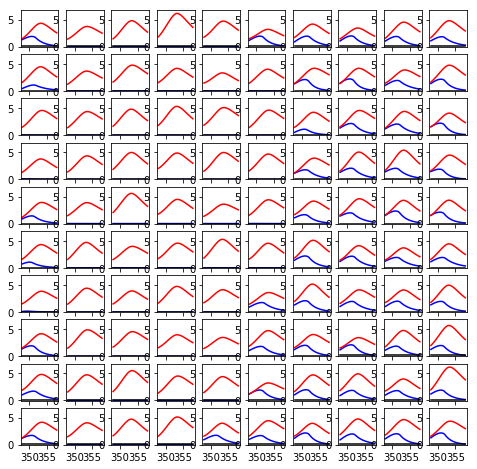

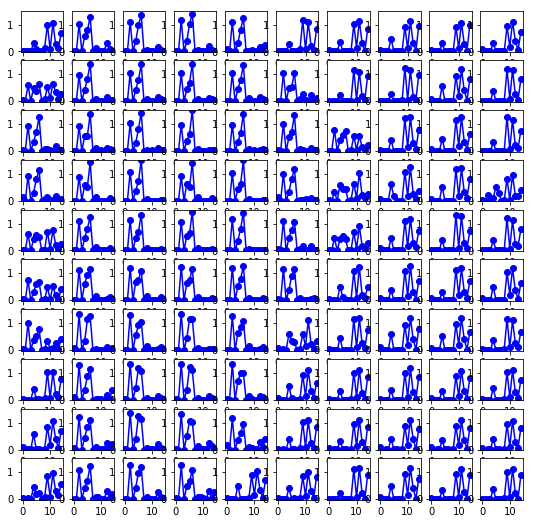

Presentation 30


In [4]:
""" Running a simulation. """
# create a parameters object with the default values
p = parameters()

# Set any parameter values specific to this simulation
p.N = 10 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.
p.IE_mask = {'circular':{'radius':1.9}}
p.IE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 2.}}
p.EI_mask = {'annular':{'inner_radius' : 1.5, 'outer_radius':2.7}}
p.EI_kernel = {'linear' : {'c' : 1.1, 'a' : 0.2}}
p.EE_mask = {'circular':{'radius':2.1}}
p.EE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 1.5}}
p.EI_weights = {'uniform' : {'low' : 0.06, 'high' : 0.2}}
p.pat_type = 'snake'

# Initialize a simulation object with the specific parameters
sel = selection(p) 

# Create all the draculab objects and the input patterns
sel.build()

# Show the input patterns
sel.display_inputs()

# Run the simulation
n_pres = 30 # number of input patterns to present
n_disp = 2  # number of times outputs will be displayed
sel.run(n_pres, n_disp)

# profiling run
#import cProfile
#import pstats

#cProfile.run('sel.run(n_pres, n_disp)', 'restats')
#prof = pstats.Stats('restats')
#prof.sort_stats('cumulative').print_stats(30)
# 280.896 seconds